In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import random
from tqdm import tqdm
import os
import cv2
import pickle

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model


import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


from tensorflow.keras.applications import ResNet50V2, ResNet101V2, ResNet152V2
from tensorflow.keras.applications.resnet_v2 import decode_predictions, preprocess_input
from tensorflow.keras.preprocessing import image


# Feature Extraction

In [2]:
IMG_SIZE=224
img_arr = []
labels = []
label_encoder = LabelEncoder()

FLOWER_DAISY_DIR = "../input/flowers-recognition/flowers/daisy/"
FLOWER_DANDELION_DIR = "../input/flowers-recognition/flowers/dandelion/"
FLOWER_ROSE_DIR = "../input/flowers-recognition/flowers/rose/"
FLOWER_SUNFLOWER_DIR = "../input/flowers-recognition/flowers/sunflower/"
FLOWER_TULIP_DIR = "../input/flowers-recognition/flowers/tulip/"

In [3]:
# Creating funtion to assign labels to each flower
#image_cust = []
def feature_extraction(path, flower_type):
    
    label = str(flower_type)                # flower_type is nothing but the class label of the flower
    for img in tqdm(os.listdir(path)):      # os.listdir list all the files present in at the given location
        img_path = path + str(img)          # combining folder path and image files name
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       # Reading image file from the above location
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))        # Resizing image to dimensoion 224*224
        
        #img = np.expand_dims(img, axis=0)
        #img = preprocess_input(img)
        img_arr.append(img)       # Appending image value into a variable for further processing
        labels.append(label) 
        

In [4]:
def pre_process():
    # Following code will check for the presence of store image array and corresponding label in current working directory.
    # If both files are present in CWD then we'll directly load that file to avoide re-processing
    global img_arr
    global labels
    if os.path.isfile("img_arr_224.npy") and os.path.isfile("labels_224.npy"):
        print("Reading file....")
        img_arr = np.load("img_arr_224.npy")
        labels = np.load("labels_224.npy")
        print("Done...")

    else:

        # Creating list for storing image value and labels
        
        print("Pre-processing....")
        print("Flower -> Daisy....")
        feature_extraction(FLOWER_DAISY_DIR, "daisy")  # calling function to assign label to all images present at given dir location

        print("Flower -> Dandelion....")
        feature_extraction(FLOWER_DANDELION_DIR, "dandelion")

        print("Flower -> Rose....")
        feature_extraction(FLOWER_ROSE_DIR, "rose")

        print("Flower -> Sunflower....")
        feature_extraction(FLOWER_SUNFLOWER_DIR, "sunflower")

        print("Flower -> Tuplip....")
        feature_extraction(FLOWER_TULIP_DIR, "tulip")

                                                   # Saving image and label array in cwd
        img_arr = np.array(img_arr)
        labels = np.array(labels)

        
        labels = label_encoder.fit_transform(labels) # Encoding all the labels into 0s and 1s
        labels = to_categorical(labels,5)                 # As we are dealing with multiclass classification hear I'm performing onHotEncoding
        img_arr = np.array(img_arr)                    
        img_arr = img_arr/255                                # Normalizing image array

        pickle.dump(label_encoder, open("label_encoder.pkl", "wb"))
        np.save("img_arr_224.npy", img_arr)
        np.save("labels_224.npy", labels)

        print("Done...")

np.random.seed(42)

# Modeling...

In [3]:
def fit_model(model):
    # Compiling the model
    
    model.compile(
        optimizer=Adam(lr=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )
    
    
    batch_size = 64
    epochs = 50

    # ModelCheckpoint ->   Callback is used in conjunction with training using model.fit() to save a model or weights
    # ReduceLROnPlateau -> Reduce learning rate when a metric has stopped improving.
    # EarlyStoppingStop -> Stop training when a monitored metric has stopped improving
    
    # monitor: quantity to be monitored.
    # factor: factor by which the learning rate will be reduced. new_lr = lr * factor.
    # patience: number of epochs with no improvement after which learning rate will be reduced.
    # verbose: int. 0: quiet, 1: update messages.
    # min_lr: lower bound on the learning rate.

    from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
    
    mcp_save = ModelCheckpoint('resnet_model.h5', save_best_only=True, monitor='val_accuracy', mode='min')
    earlyStopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=0, mode='auto', restore_best_weights=True)
    red_lr= ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5)
    
    
    
    # Fitting on training set and using validation set
    history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                        epochs = epochs, 
                        validation_data = (X_test, y_test),
                        callbacks=[red_lr, earlyStopping, mcp_save],
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        verbose=1)
    
    print("\n\n Model Evalation: \n\n")
    print(model.evaluate(X_test, y_test))
    return history

In [4]:
# Saving all preprocessed and splitted file on local disk so we don't have to perform again.
# Loading processed training and testing data from storage

if os.path.isfile("X_train.npy") and os.path.isfile("X_train.npy") and os.path.isfile("y_train.npy") and os.path.isfile("y_test.npy"):
    print("Loading training and testing data from storage...")
    label_encoder = pickle.load(open("label_encoder.pkl", "rb"))
    X_train = np.load("X_train.npy")
    X_test = np.load("X_test.npy")
    y_train = np.load("y_train.npy")
    y_test = np.load("y_test.npy")
    print("Done...")
else: 
    pre_process()  # If preprocessed files are not present on disk then here I'm calling pre_process function to process image data
    print("Spliting data into training and test set.....")
    X_train, X_test, y_train, y_test = train_test_split(img_arr, labels, stratify = labels, test_size=0.2, random_state=42)
    
    print("Saving train and test set")
    np.save("X_train.npy", X_train)
    np.save("X_test.npy", X_test)
    np.save("y_train.npy", y_train)
    np.save("y_test.npy", y_test)
    print("Done...")

np.random.seed(42)

Loading training and testing data from storage...
Done...


# Data Agumentation

In [5]:
datagen = ImageDataGenerator(
    featurewise_center= False,    # set input mean to 0 over the dataset
    samplewise_center= False,     # set each sample mean to 0
    featurewise_std_normalization= False,   # divide inputs by std of the dataset
    samplewise_std_normalization= False,   # divide each input by its std
    zca_whitening= False,         # apply ZCA whitening
    rotation_range=10,            # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1,             # Randomly zoom image 
    width_shift_range=0.2,        # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,       # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,         # randomly flip images
    vertical_flip=False          # randomly flip images

)

datagen.fit(X_train)

# RESNET50

In [6]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
def load_resnet_50():
    print("Pre-trained RESNET50 model without top layers....\n")
    model_50 = Sequential()
    model_50.add(ResNet50V2(
                weights="imagenet",
                include_top=False,
                input_shape=(IMG_SIZE,IMG_SIZE,3), 
                pooling='avg',
                classes=5,                           # no of classes present in data
                classifier_activation="softmax"
        ))

    

    #for layer in model.layers[:-7]:
     #   layer.trainable = False
        
    model_50.add(Flatten())
    model_50.add(BatchNormalization())
    model_50.add(Dense(2048, activation='relu'))
    #model_50.add(Dropout(0.2))
    model_50.add(BatchNormalization())
    model_50.add(Dense(1024, activation='relu'))
    #model_50.add(Dropout(0.2))
    model_50.add(BatchNormalization())
    model_50.add(Dense(5, activation='softmax'))
    
    model_50.layers[0].trainable = False        # Setting trainable parameter to False for resnet50v2 pretrained model
    return model_50

In [7]:
resnet_50 = load_resnet_50()
resnet_50.summary()

2022-03-13 14:54:46.071328: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-13 14:54:46.177417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-13 14:54:46.178327: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-13 14:54:46.180435: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94683136/94668760 [==============================] - 1s 0us/step
Pre-trained RESNET50 model without top layers....

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
______

In [8]:
history = fit_model(resnet_50)   # fitting resnet50 model to the training data

2022-03-13 14:54:54.852767: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-03-13 14:54:59.597419: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


53/53 [==============================] - ETA: 0s - loss: 1.1048 - accuracy: 0.7462

2022-03-13 14:55:40.842296: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 520224768 exceeds 10% of free system memory.
2022-03-13 14:55:41.407644: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 520224768 exceeds 10% of free system memory.


53/53 [==============================] - 50s 755ms/step - loss: 1.1048 - accuracy: 0.7462 - val_loss: 0.6103 - val_accuracy: 0.8148
Epoch 2/50
53/53 [==============================] - 37s 698ms/step - loss: 0.3910 - accuracy: 0.8604 - val_loss: 0.4521 - val_accuracy: 0.8495
Epoch 3/50
53/53 [==============================] - 39s 727ms/step - loss: 0.2682 - accuracy: 0.9026 - val_loss: 0.4361 - val_accuracy: 0.8576
Epoch 4/50
53/53 [==============================] - 38s 718ms/step - loss: 0.2665 - accuracy: 0.9076 - val_loss: 0.4501 - val_accuracy: 0.8507
Epoch 5/50
53/53 [==============================] - 38s 709ms/step - loss: 0.2198 - accuracy: 0.9183 - val_loss: 0.4987 - val_accuracy: 0.8530
Epoch 6/50
53/53 [==============================] - 37s 694ms/step - loss: 0.2137 - accuracy: 0.9242 - val_loss: 0.4594 - val_accuracy: 0.8646
Epoch 7/50
53/53 [==============================] - 38s 709ms/step - loss: 0.1866 - accuracy: 0.9265 - val_loss: 0.4482 - val_accuracy: 0.8646
Epoch 8/50

2022-03-13 15:07:23.101315: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 520224768 exceeds 10% of free system memory.
2022-03-13 15:07:23.699898: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 520224768 exceeds 10% of free system memory.


27/27 [==============================] - 1s 54ms/step - loss: 0.5545 - accuracy: 0.8843
[0.554544985294342, 0.8842592835426331]


### Here we got 88.5% accuracy using RESNET50V2 model

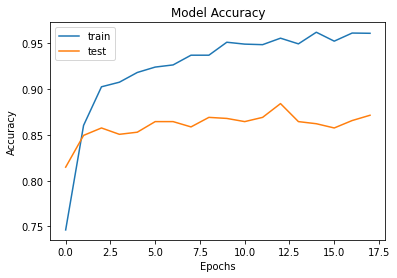

In [9]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

# RESNET_101V2

In [5]:
def load_resnet_101():
    model101 = Sequential()
    model101.add(ResNet101V2(
                weights="imagenet",
                include_top=False,
                input_shape=(IMG_SIZE,IMG_SIZE,3),
                pooling='avg',
                classes=5,
                classifier_activation="softmax"
        ))

    print("Pre-trained RESNET50 model without top layers....\n")

    #for layer in model.layers[:-7]:
     #   layer.trainable = False
        
    model101.add(Flatten())
    model101.add(BatchNormalization())
    model101.add(Dense(2048, activation='relu'))
    model101.add(Dropout(0.2))
    model101.add(BatchNormalization())
    model101.add(Dense(1024, activation='relu'))
    model101.add(Dropout(0.2))
    model101.add(BatchNormalization())
    model101.add(Dense(5, activation='softmax'))
    
    model101.layers[0].trainable = False
    return model101

In [8]:
resnet_101 = load_resnet_101()
resnet_101.summary()

Pre-trained RESNET50 model without top layers....

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Functional)     (None, 2048)              42626560  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
den

In [11]:
history = fit_model(resnet_101)

2022-03-13 15:21:02.211080: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-03-13 15:21:09.395558: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


53/53 [==============================] - ETA: 0s - loss: 0.9455 - accuracy: 0.7636

2022-03-13 15:21:51.629876: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 520224768 exceeds 10% of free system memory.
2022-03-13 15:21:52.243263: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 520224768 exceeds 10% of free system memory.


53/53 [==============================] - 57s 855ms/step - loss: 0.9455 - accuracy: 0.7636 - val_loss: 0.7240 - val_accuracy: 0.8148
Epoch 2/50
53/53 [==============================] - 40s 748ms/step - loss: 0.4642 - accuracy: 0.8480 - val_loss: 0.4800 - val_accuracy: 0.8565
Epoch 3/50
53/53 [==============================] - 39s 741ms/step - loss: 0.3426 - accuracy: 0.8814 - val_loss: 0.5276 - val_accuracy: 0.8403
Epoch 4/50
53/53 [==============================] - 39s 742ms/step - loss: 0.3028 - accuracy: 0.8893 - val_loss: 0.4395 - val_accuracy: 0.8530
Epoch 5/50
53/53 [==============================] - 39s 738ms/step - loss: 0.2400 - accuracy: 0.9153 - val_loss: 0.4636 - val_accuracy: 0.8565
Epoch 6/50
53/53 [==============================] - 40s 748ms/step - loss: 0.2475 - accuracy: 0.9094 - val_loss: 0.4764 - val_accuracy: 0.8565
Epoch 7/50
53/53 [==============================] - 39s 741ms/step - loss: 0.2125 - accuracy: 0.9292 - val_loss: 0.5252 - val_accuracy: 0.8519


 Model E

2022-03-13 15:26:04.909943: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 520224768 exceeds 10% of free system memory.
2022-03-13 15:26:05.496454: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 520224768 exceeds 10% of free system memory.


27/27 [==============================] - 3s 93ms/step - loss: 0.4800 - accuracy: 0.8565
[0.4799584150314331, 0.8564814925193787]


## Here we got 85.7% accuracy using RESNET-101V2 model

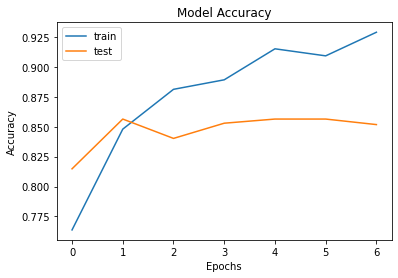

In [12]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

# RESNET_152V2

In [6]:
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
def load_resnet_152():
    model_152 = Sequential()
    model_152.add(ResNet152V2(
                weights="imagenet",
                include_top=False,
                input_shape=(IMG_SIZE,IMG_SIZE,3),
                pooling='avg',
                classes=5,
                classifier_activation="softmax"
        ))

    print("Pre-trained RESNET50 model without top layers....\n")

    #for layer in model.layers[:-7]:
     #   layer.trainable = False
        
    model_152.add(Flatten())
    model_152.add(BatchNormalization())
    model_152.add(Dense(2048, activation='relu'))
    #model_152.add(Dropout(0.2))
    model_152.add(BatchNormalization())
    model_152.add(Dense(1024, activation='relu'))
    #model_152.add(Dropout(0.2))
    model_152.add(BatchNormalization())
    model_152.add(Dense(5, activation='softmax'))
    
    model_152.layers[0].trainable = False
    return model_152

In [7]:
model_152 = load_resnet_152()
model_152.summary()

2022-03-13 15:50:56.493996: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-13 15:50:56.583344: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-13 15:50:56.584031: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-13 15:50:56.586771: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Pre-trained RESNET50 model without top layers....

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 2048)              58331648  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
batch

In [8]:
history = fit_model(model_152)

2022-03-13 15:51:07.579787: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-03-13 15:51:17.078703: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


53/53 [==============================] - ETA: 0s - loss: 1.0409 - accuracy: 0.7527

2022-03-13 15:52:00.966006: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 520224768 exceeds 10% of free system memory.
2022-03-13 15:52:01.543044: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 520224768 exceeds 10% of free system memory.


53/53 [==============================] - 62s 896ms/step - loss: 1.0409 - accuracy: 0.7527 - val_loss: 0.6461 - val_accuracy: 0.8345
Epoch 2/50
53/53 [==============================] - 42s 800ms/step - loss: 0.4373 - accuracy: 0.8528 - val_loss: 0.4428 - val_accuracy: 0.8542
Epoch 3/50
53/53 [==============================] - 42s 790ms/step - loss: 0.3090 - accuracy: 0.8947 - val_loss: 0.4207 - val_accuracy: 0.8681
Epoch 4/50
53/53 [==============================] - 43s 809ms/step - loss: 0.2799 - accuracy: 0.9012 - val_loss: 0.4444 - val_accuracy: 0.8600
Epoch 5/50
53/53 [==============================] - 43s 802ms/step - loss: 0.2216 - accuracy: 0.9239 - val_loss: 0.4272 - val_accuracy: 0.8669
Epoch 6/50
53/53 [==============================] - 42s 796ms/step - loss: 0.2299 - accuracy: 0.9180 - val_loss: 0.4674 - val_accuracy: 0.8588
Epoch 7/50
53/53 [==============================] - 44s 837ms/step - loss: 0.2116 - accuracy: 0.9253 - val_loss: 0.5416 - val_accuracy: 0.8634
Epoch 8/50

2022-03-13 16:03:24.067519: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 520224768 exceeds 10% of free system memory.
2022-03-13 16:03:24.717137: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 520224768 exceeds 10% of free system memory.


27/27 [==============================] - 4s 129ms/step - loss: 0.5134 - accuracy: 0.8715
[0.5133639574050903, 0.8715277910232544]


## We got 87.2% accuracy using RESNET_152V2 model

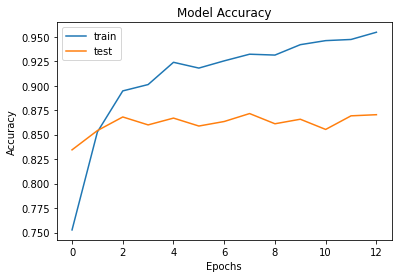

In [9]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()